# LinkedIn Job Postings

## imports

In [ ]:
! pip install kaggle

In [ ]:
pip install chart-studio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 5.7 MB/s eta 0:00:00


In [90]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import plotly.express as px
import chart_studio
import chart_studio.plotly as py

## load datasets

In [ ]:
#no need to rerun btw sessions
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#if rerunning, replace all [A], then yes [y]
! mkdir ~/.kaggle
%cd ~/.kaggle
! cp /content/drive/MyDrive/Colab_Notebooks/Kaggle_API/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download arshkon/linkedin-job-postings
! unzip linkedin-job-postings.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
/root/.kaggle
Dataset URL: https://www.kaggle.com/datasets/arshkon/linkedin-job-postings
License(s): CC-BY-SA-4.0
linkedin-job-postings.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  linkedin-job-postings.zip
replace companies/companies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [86]:
# postings.csv
postings = pd.read_csv('./postings.csv')
postings.head(1)

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0


In [91]:
df = postings

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   max_salary                  29793 non-null   float64
 5   pay_period                  36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary                  6280 non-null    float64
 10  min_salary                  29793 non-null   float64
 11  formatted_work_type         123849 non-null  object 
 12  applies                     23320 non-null   float64
 13  original_liste

In [89]:
df.isnull().sum()

,0
job_id,0
company_name,1719
title,0
description,7
max_salary,94056
pay_period,87776
location,0
company_id,1717
views,1689
med_salary,117569


## Data Visualizations

### job postings over time

In [92]:
df_date = df.copy()

#covert fips to date time
df_date['listed_datetime'] = pd.to_datetime(df['listed_time'], unit='ms')

#extract month year from date
df_date['month_year'] = df_date['listed_datetime'].dt.strftime('%b %Y')

df_date.head(1)

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips,listed_datetime,month_year
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0,2024-04-17 23:45:08,Apr 2024


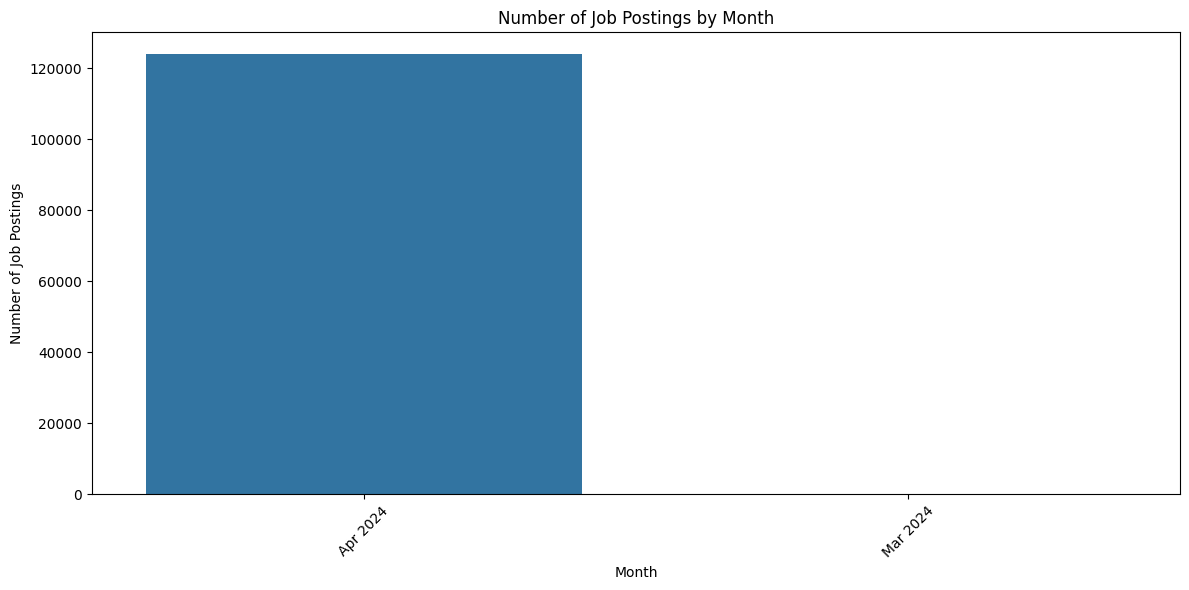

In [93]:
#Count job postings per month
monthly_counts = df_date['month_year'].value_counts().sort_index()

#Plot as bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values)
plt.title('Number of Job Postings by Month')
plt.xlabel('Month')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### normalized salary

In [94]:
#explore salary range
# pd.set_option('display.float_format', '{:.1f}'.format)
df['normalized_salary'].describe()

,normalized_salary
count,3.607300e+04
mean,2.053270e+05
std,5.097627e+06
min,0.000000e+00
25%,5.200000e+04
50%,8.150000e+04
75%,1.250000e+05
max,5.356000e+08


Salary before removing outliers

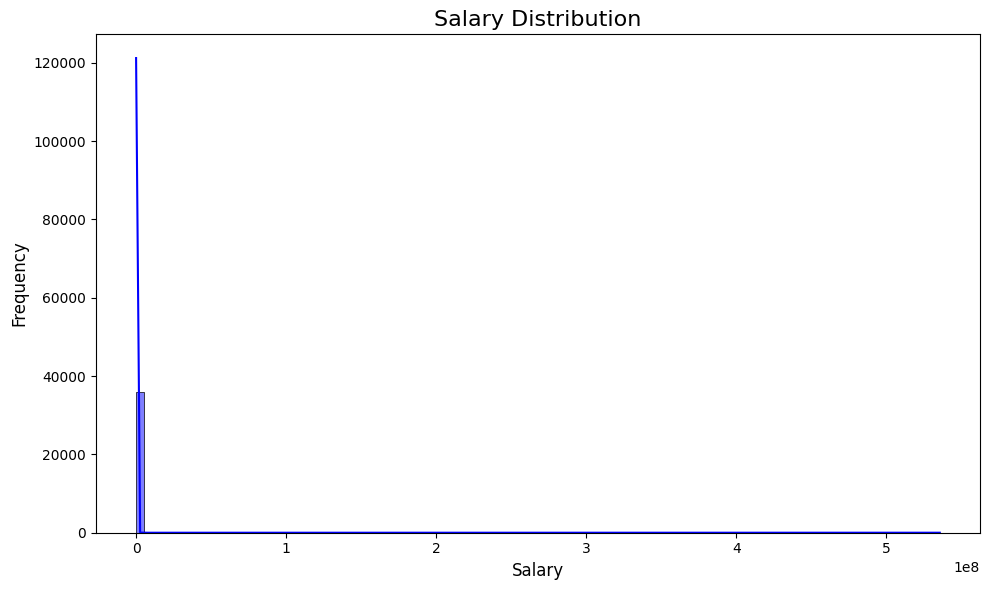

In [95]:
salary_column = df['normalized_salary']

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(salary_column, kde=True, bins=100, color='blue')
plt.title('Salary Distribution', fontsize=16)
plt.xlabel('Salary', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

remove outliers

In [96]:
#filter federal minimum annual wage($15,080) & outlier values
lower_threshold = 15080
upper_threshold = 300000

# Remove rows outside thresehold
df_salary = df.copy()
df_salary = df[(df['normalized_salary'] >= lower_threshold) & (df['normalized_salary'] <= upper_threshold)]

Salary after removing outliers

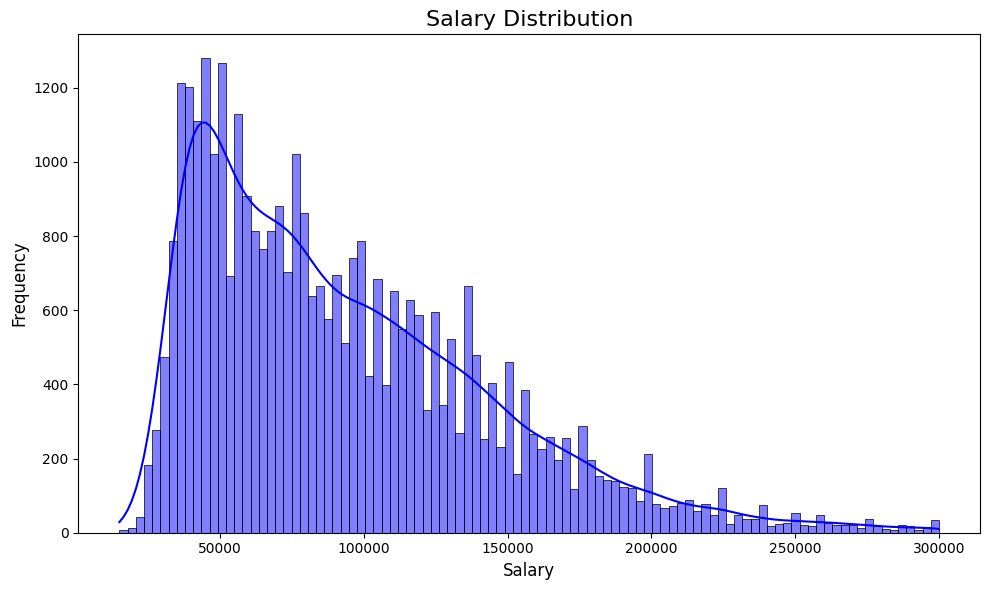

In [97]:
salary_column = df_salary['normalized_salary']

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(salary_column, kde=True, bins=100, color='blue')
plt.title('Salary Distribution', fontsize=16)
plt.xlabel('Salary', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

### location

In [99]:
# Extract state from location
df_state = df.copy()
df_state['state'] = df['location'].str.extract(r', ([A-Z]{2})$')
df_state.head(1)

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips,state
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0,NJ


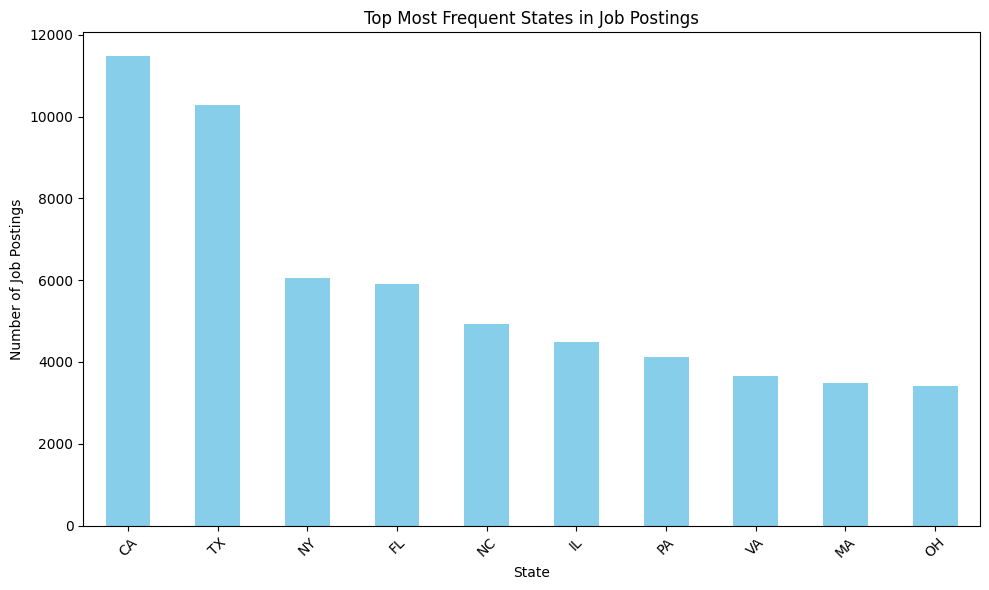

In [ ]:
#Count job postings per state
state_counts = df_state['state'].value_counts().nlargest(10)

#Plot as bar chart
plt.figure(figsize=(10, 6))
state_counts.plot(kind='bar')
plt.title('Top Most Frequent States in Job Postings')
state_counts.plot(kind='bar', color='skyblue')
plt.xlabel('State')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [101]:
# Drop missing FIPS values
df_loc = df.copy()
df_loc = df.dropna(subset=['fips'])

# Ensure FIPS is a 5-digit zero-padded string
df_loc['county_fips'] = df_loc['fips'].astype(int).astype(str).str.zfill(5)

# Count job postings per county
county_counts = df_loc['county_fips'].value_counts().reset_index()
county_counts.columns = ['fips', 'job_postings']

# Create county-level choropleth map
fig = px.choropleth(
    county_counts,
    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
    locations='fips',
    color='job_postings',
    color_continuous_scale='Blues',
    scope='usa',
    labels={'job_postings': 'Job Postings'},
    title='Job Postings by U.S. County'
)

fig.update_geos(fitbounds="locations", visible=False)
fig.show()


<ipython-input-101-c8aa2e22eeb5>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [102]:
#generate website link
chart_studio.tools.set_credentials_file(username='ldo7', api_key='gj579j59AdPFgD8BWROK')
link = py.plot(fig, filename='my-plot', auto_open=False)
print("Plot link:", link)

Plot link: https://chart-studio.plotly.com/~ldo7/1/


### job title

Text(0.5, 1.0, 'Job Title Word Cloud')

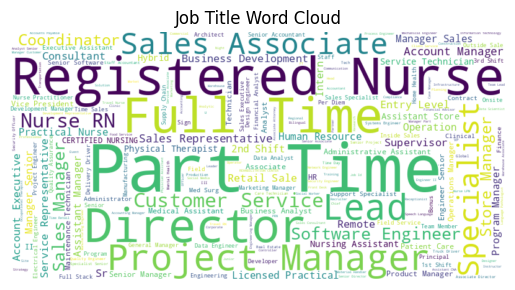

In [103]:
from wordcloud import WordCloud

text = ' '.join(df['title'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Job Title Word Cloud')

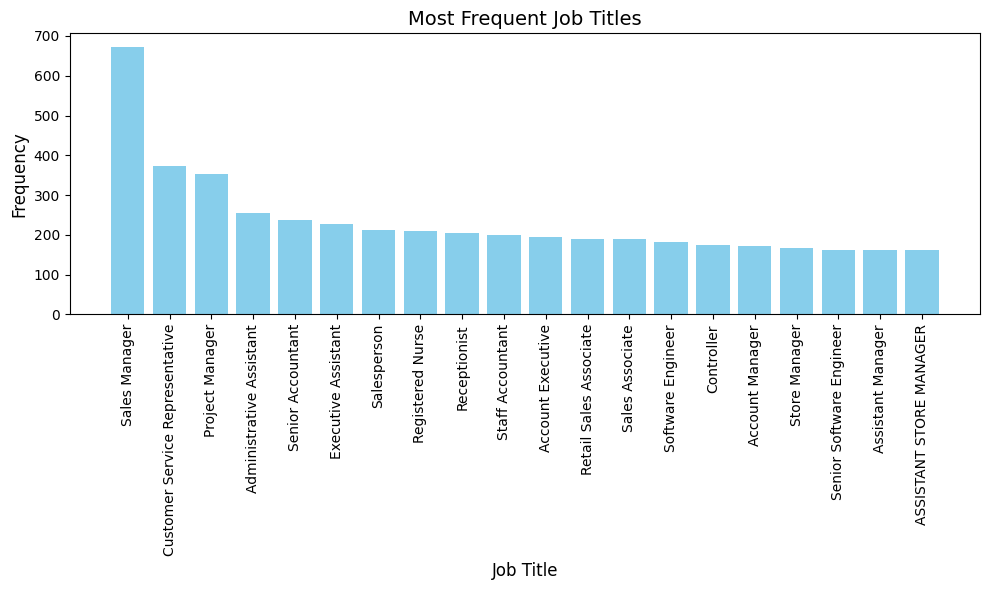

In [104]:
# Calculate the frequencies
value_counts = df['title'].value_counts()

# Get the top values
top_titles = value_counts.head(20)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_titles.index, top_titles.values, color='skyblue')
plt.xlabel('Job Title', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f"Most Frequent Job Titles", fontsize=14)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

### company

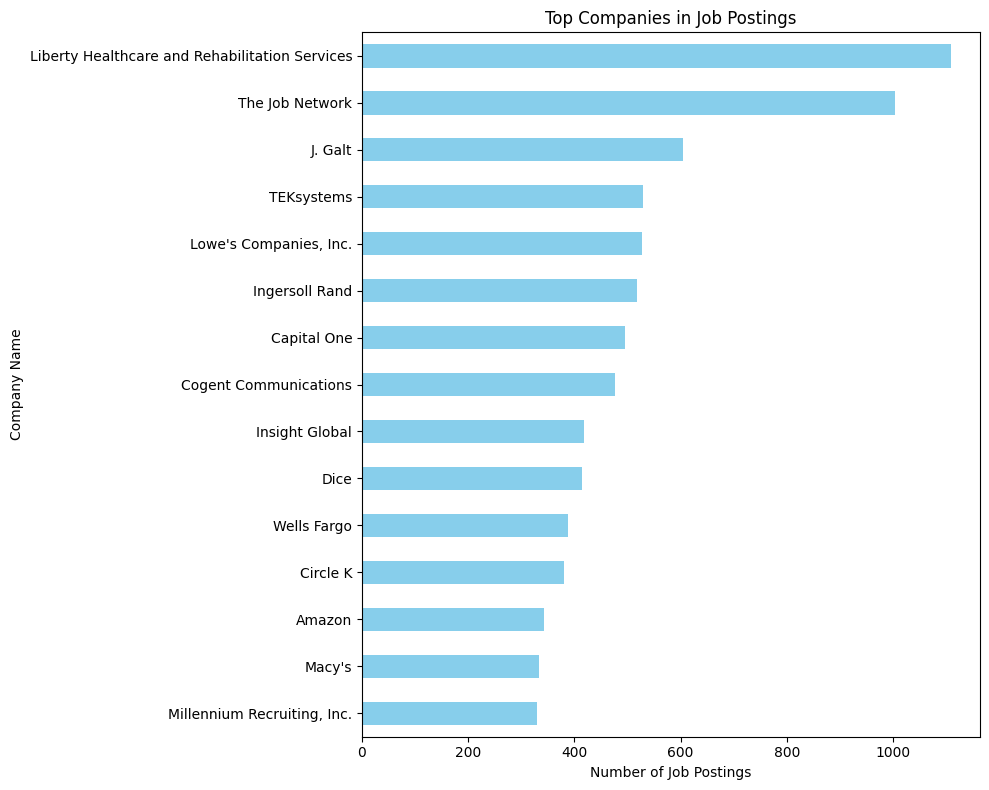

In [105]:
# Get top companies by job postings and sort ascending for top-down display
company_counts = df['company_name'].value_counts().nlargest(15).sort_values()

# Create horizontal bar chart
plt.figure(figsize=(10, 8))
company_counts.plot(kind='barh', color='skyblue')
plt.title('Top Companies in Job Postings')
plt.xlabel('Number of Job Postings')
plt.ylabel('Company Name')
plt.tight_layout()
plt.show()


# Data Pre-processing

## Clean Data

In [106]:
#ROWS
#drop rows that don't contain target value
df = df.dropna(subset=['normalized_salary'])

#drop rows where NaN only <10% of dataset
df = df.dropna(subset=['views','company_name','description','company_id','views'])
df = df[df["application_type"] != "UnknownApply"]

#drop rows where NaN only lose ~20% of dataset
df = df.dropna(subset=['zip_code','fips'])

#drop rows cuz idk how to fill in blanks
df = df.dropna(subset=['formatted_experience_level'])

# Remove rows where 'currency' column is not 'USD' (case insensitive)
df = df[df['currency'].str.lower() == 'usd']

# Remove rows where 'pay_period' column is not 'yearly' (case insensitive)
df = df[df['pay_period'].str.lower() == 'yearly']

# # Remove rows where 'work_type' column is not 'full-time' (case insensitive)
df = df[df['work_type'].str.lower() == 'full_time']

In [107]:
#COLUMNS
#too many null values (90%+)
df = df.drop(['skills_desc','applies','closed_time','remote_allowed'], axis=1)

#drop columns 100% unique values OR obviously irrelevant
df = df.drop(['job_id','job_posting_url','application_url','posting_domain'], axis=1)

#use normalized salary
df = df.drop(['min_salary','max_salary','med_salary'], axis=1)

#repetitive data - aka there exists another related column
df = df.drop(['company_name', 'location','work_type'], axis=1)

#all rows have same value (after filtering rows for NaNs)
df = df.drop(['compensation_type','currency','pay_period', 'sponsored','formatted_work_type'], axis=1)

In [108]:
#COLUMNS
  #long string value / cannot cleanly divide into categories - try TF-IDF later...
df = df.drop(['description','title'], axis=1)

In [110]:
df.isnull().sum()

,0
company_id,0
views,0
original_listed_time,0
application_type,0
expiry,0
formatted_experience_level,0
listed_time,0
normalized_salary,0
zip_code,0
fips,0


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10528 entries, 101 to 123848
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   company_id                  10528 non-null  float64
 1   views                       10528 non-null  float64
 2   original_listed_time        10528 non-null  float64
 3   application_type            10528 non-null  object 
 4   expiry                      10528 non-null  float64
 5   formatted_experience_level  10528 non-null  object 
 6   listed_time                 10528 non-null  float64
 7   normalized_salary           10528 non-null  float64
 8   zip_code                    10528 non-null  float64
 9   fips                        10528 non-null  float64
dtypes: float64(8), object(2)
memory usage: 904.8+ KB


In [ ]:
#identify most freq occuring values in each column
for col in df.columns:
    print(f"Value counts for column: {col}")
    print(df[col].value_counts(dropna=False))
    print("-" * 40)

Value counts for column: company_id
company_id
18860134.0    135
248184.0      129
1586.0         88
11056.0        87
21836.0        86
             ... 
1499970.0       1
311752.0        1
52945.0         1
26162.0         1
70473170.0      1
Name: count, Length: 3738, dtype: int64
----------------------------------------
Value counts for column: views
views
4.0      2125
3.0      1325
2.0      1129
5.0      1068
6.0       617
         ... 
154.0       1
334.0       1
158.0       1
99.0        1
663.0       1
Name: count, Length: 211, dtype: int64
----------------------------------------
Value counts for column: original_listed_time
original_listed_time
1.713398e+12    528
1.713312e+12    302
1.713485e+12    238
1.712794e+12    147
1.712275e+12    137
               ... 
1.713280e+12      1
1.713281e+12      1
1.713281e+12      1
1.713280e+12      1
1.713281e+12      1
Name: count, Length: 7720, dtype: int64
----------------------------------------
Value counts for column: applicatio

## Target Correlation Heatmap

<Axes: >

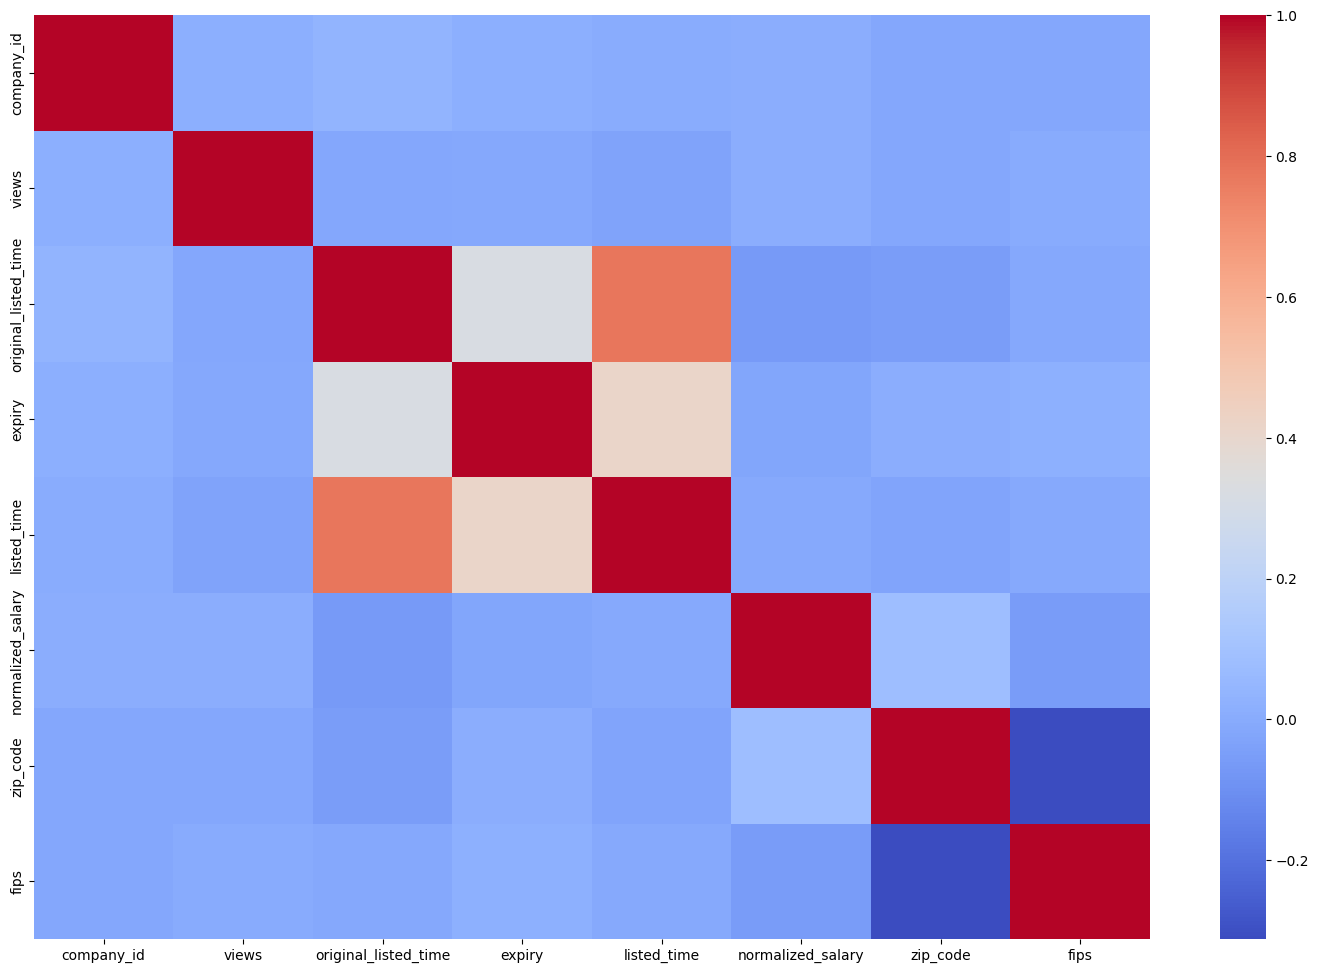

In [ ]:
#correlation heatmap - identify least important features
df_num = df[['company_id','views','original_listed_time','expiry','listed_time','normalized_salary','zip_code','fips']]
plt.figure(figsize=(18,12))
sns.heatmap(df_num.corr(), annot=False, cmap='coolwarm')

# ML model

imports

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score

### helper functions

compare ML models

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

categorize salary output

In [ ]:
def classify_salary_range(prediction):
    salary = prediction[0]
    if salary <= 30000:
        return '<= $30K'
    elif 30001 <= salary <= 58020:
        return '$30K – $58K'
    elif 58021 <= salary <= 94000:
        return '$58K – $94K'
    elif 94001 <= salary <= 153000:
        return '$94K – $153K'
    else:
        return '> $153K'

## Test/Train Split

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#use 20% data for testing
#train_df, test_df = train_test_split(df, test_size=0.2, random_state = 42)

df['salary_cat'] = pd.cut(df['normalized_salary'],
                               bins=[0.0, 30000, 58020, 94000, 153000, 200000],
                               labels=["Lower", "Lower-Middle", "Middle", "Upper-Middle", "Upper"])

df["salary_cat"] = df["salary_cat"].astype(str)

In [ ]:
# Use StratifiedShuffleSplit for creating train and test splits
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['salary_cat']):
    train_df = df.iloc[train_index].copy()
    test_df = df.iloc[test_index].copy()

# Remove the salary_cat column after splitting (only used for stratification)
for set_ in (train_df, test_df):
    set_.drop("salary_cat", axis=1, inplace=True)

In [ ]:
#delete target column to predict
#train
train_X = train_df.drop('normalized_salary', axis=1)
train_y = train_df['normalized_salary']

#test
test_X = test_df.drop('normalized_salary', axis=1)
test_y = test_df['normalized_salary']

In [ ]:
# remove entries where the test set contains states that are missing in the training set
train_states = set(train_X["state"])
test_states = set(test_X["state"])

missing_states = train_states - test_states
print("States in test but missing in train:", missing_states)

States in test but missing in train: {'WY'}


In [ ]:
df.state.value_counts()

,count
state,
CA,1963
NY,1405
TX,720
FL,478
IL,433
WA,407
CO,357
NJ,347
MA,338


In [ ]:
train_X = train_X[~train_X["state"].isin(missing_states)]
train_y = train_y.loc[train_X.index]

## Transformation Pipeline

In [ ]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8199 entries, 56813 to 91802
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   company_id                  8199 non-null   float64
 1   views                       8199 non-null   float64
 2   original_listed_time        8199 non-null   float64
 3   application_type            8199 non-null   object 
 4   expiry                      8199 non-null   float64
 5   formatted_experience_level  8199 non-null   object 
 6   listed_time                 8199 non-null   float64
 7   zip_code                    8199 non-null   float64
 8   fips                        8199 non-null   float64
 9   state                       8199 non-null   object 
dtypes: float64(7), object(3)
memory usage: 704.6+ KB


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# numerical and categorical columns (except remote_allowed which is a binary category)
#df_num = train_X[['job_id','company_id', 'views','original_listed_time','expiry','listed_time','zip_code']]
df_num = train_X[['company_id', 'views','original_listed_time','expiry','listed_time', 'zip_code', 'fips']]
df_cat = train_X[['application_type','formatted_experience_level', 'state']]

num_attribs = list(df_num)
cat_attribs = list(df_cat)

# one-hot encoding
cat_encoder = OneHotEncoder()
df_cat_1hot = cat_encoder.fit_transform(df_cat)
df_cat_1hot

# Pipeline for numerical attributes
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), # fill in missing values with median values
        ('std_scaler', StandardScaler()),              # feature scaling
    ])

df_num_tr = num_pipeline.fit_transform(df_num)

# Complete the pipeline with combine categorical attributes
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

train_X_prepared = full_pipeline.fit_transform(train_X)
cols = list(df_num) + [cat for sublist in cat_encoder.categories_ for cat in sublist]

In [ ]:
train_X_prepared = train_X_prepared.toarray()
## Convert the 2D array into Pandas DataFrame
train_X_prep = pd.DataFrame(
    train_X_prepared,
    columns=cols,
    index=train_X.index)
train_X_prepared = train_X_prep.to_numpy()

In [ ]:
train_X_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8199 entries, 56813 to 91802
Data columns (total 66 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   company_id            8199 non-null   float64
 1   views                 8199 non-null   float64
 2   original_listed_time  8199 non-null   float64
 3   expiry                8199 non-null   float64
 4   listed_time           8199 non-null   float64
 5   zip_code              8199 non-null   float64
 6   fips                  8199 non-null   float64
 7   ComplexOnsiteApply    8199 non-null   float64
 8   OffsiteApply          8199 non-null   float64
 9   SimpleOnsiteApply     8199 non-null   float64
 10  Associate             8199 non-null   float64
 11  Director              8199 non-null   float64
 12  Entry level           8199 non-null   float64
 13  Executive             8199 non-null   float64
 14  Internship            8199 non-null   float64
 15  Mid-Senior level     

<Axes: >

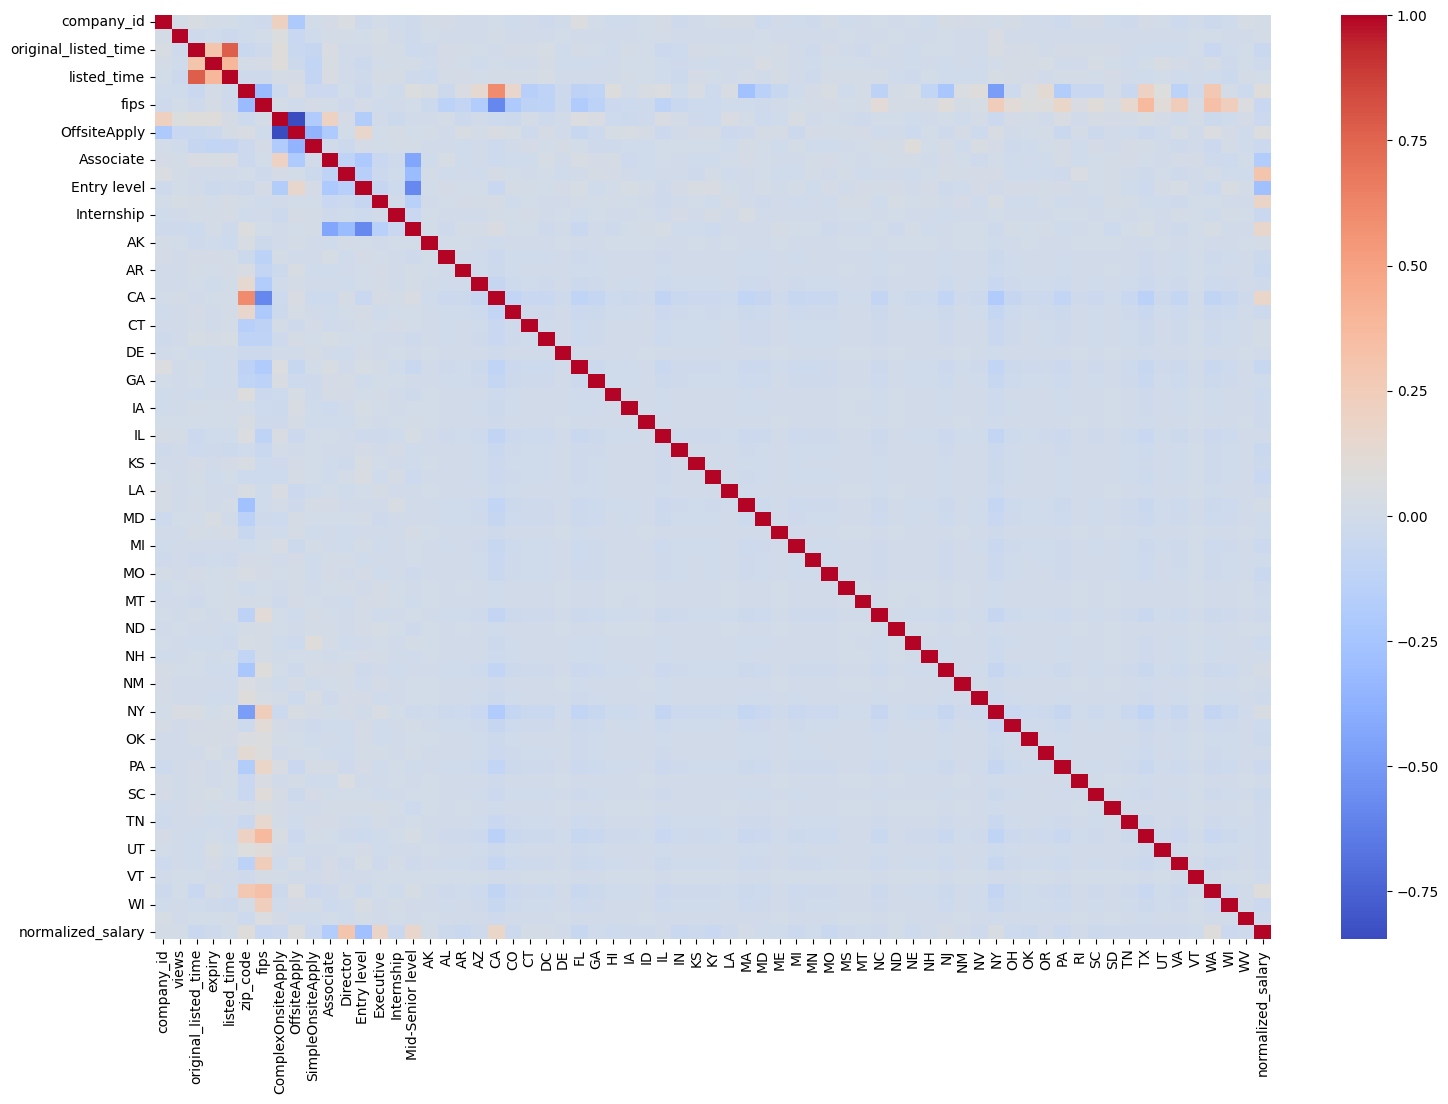

In [ ]:
train_salary = pd.concat([train_X_prep, train_df[['normalized_salary']]], axis=1)
# correlation heatmap
plt.figure(figsize=(18,12))
sns.heatmap(train_salary.corr(), annot=False, cmap='coolwarm')

In [ ]:
train_y.head()

,normalized_salary
56813,100000.0
77286,85000.0
50847,37500.0
30377,20959.0
100928,76500.0


## Random Forest

In [ ]:
#run ML model
forest = RandomForestRegressor(n_estimators=10,random_state=42) #crashes at 30
forest.fit(train_X_prepared, train_y)

RandomForestRegressor(n_estimators=10, random_state=42)

In [ ]:
#prediction
Y_pred=forest.predict(train_X_prepared)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

In [ ]:
forest_mse = mean_squared_error(train_y, Y_pred)
# Root Mean Square Error (RMSE) for performance measure
forest_rmse = np.sqrt(forest_mse)
print("forest_rmse:", forest_rmse)
# Mean Absolute Error
forest_mae = mean_absolute_error(train_y, Y_pred)
print("forest_mae:", forest_mae)

forest_rmse: 17736.032729033486
forest_mae: 12600.269539914856


In [ ]:
# cross validation
forest_scores = cross_val_score(forest, train_X_prepared, train_y,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [43158.47666733 42210.57151622 40110.12763756 43098.15780642
 43716.25657422 43829.47579131 45721.67748937 43368.69278209
 43524.77112952 42100.87443967]
Mean: 43083.90818337102
Standard deviation: 1369.9354503999562


In [ ]:
# r-squared
r_sq = r2_score(train_y, Y_pred)
print(f'R^2: {r_sq:.2f}')

R^2: 0.88


## K-nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(train_X_prepared, train_y)

KNeighborsRegressor()

In [ ]:
Y_pred = knn.predict(train_X_prepared)
knn_mse = mean_squared_error(train_y, Y_pred)
# Root Mean Square Error (RMSE) for performace measure
knn_rmse = np.sqrt(knn_mse)
print("knn_rmse:", knn_rmse)
# Mean Absolute Error
knn_mae = mean_absolute_error(train_y, Y_pred)
print("knn_mae:", knn_mae)

knn_rmse: 37010.57952530436
knn_mae: 28059.406407854614


In [ ]:
# cross validation
knn_scores = cross_val_score(knn, train_X_prepared, train_y,
                                scoring="neg_mean_squared_error", cv=10)
knn_rmse_scores = np.sqrt(-knn_scores)
display_scores(knn_rmse_scores)

Scores: [47011.10275189 45862.23037093 42267.02060737 45252.21959008
 47058.45266459 45605.03217316 48420.72488216 47049.57516776
 45817.5283923  44366.38674196]
Mean: 45871.027334218816
Standard deviation: 1622.0082375680815


In [ ]:
# r-squared
r_sq = r2_score(train_y, Y_pred)
print(f'R^2: {r_sq:.2f}')

R^2: 0.46


## Decision Tree

In [ ]:
#ML model
tree = DecisionTreeRegressor()
tree.fit(train_X_prepared, train_y)

DecisionTreeRegressor()

In [ ]:
Y_pred = tree.predict(train_X_prepared)
tree_mse = mean_squared_error(train_y, Y_pred)
# Root Mean Square Error (RMSE) for performace measure
tree_rmse = np.sqrt(tree_mse)
print("tree_rmse:", tree_rmse)
# Mean Absolute Error
tree_mae = mean_absolute_error(train_y, Y_pred)
print("tree_mae:", tree_mae)

tree_rmse: 2251.6597780184115
tree_mae: 166.7074769280807


In [ ]:
#stats
tree_scores = cross_val_score(tree, train_X_prepared, train_y,
                                scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [58606.62020808 54641.72904595 55301.77753699 55607.38446013
 53405.67401577 55127.27875695 58653.47908044 53958.2189919
 55745.83038664 54360.70094697]
Mean: 55540.86934298101
Standard deviation: 1691.9490250944377


In [ ]:
# r-squared
r_sq = r2_score(train_y, Y_pred)
print(f'R^2: {r_sq:.2f}')

R^2: 1.00


## Fine Tuning

The K-Nearest Neighbors model has the highest Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and standard deviation, making it lowest in accuracy and stability. The Decision Tree is the most accurate machine learning model for this dataset as it has the lowest RMSE and MAE, so we will use this on our test set.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_depth': [3, 10, None], 'max_features': [2, 4, 6, 8]},
    {'criterion': ['squared_error', 'absolute_error'], 'max_features': [2, 3, 4]}
]

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(tree, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(train_X_prepared, train_y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [3, 10, None],
                          'max_features': [2, 4, 6, 8]},
                         {'criterion': ['squared_error', 'absolute_error'],
                          'max_features': [2, 3, 4]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'max_depth': 10, 'max_features': 8}

In [ ]:
print(grid_search.best_estimator_)

DecisionTreeRegressor(max_depth=10, max_features=8)


In [ ]:
# Score of each hyperparameter combination
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49362.62862820247 {'max_depth': 3, 'max_features': 2}
47824.27796055152 {'max_depth': 3, 'max_features': 4}
48827.10429979005 {'max_depth': 3, 'max_features': 6}
47596.46835007659 {'max_depth': 3, 'max_features': 8}
47384.85578757333 {'max_depth': 10, 'max_features': 2}
46483.331367773455 {'max_depth': 10, 'max_features': 4}
46916.84279395932 {'max_depth': 10, 'max_features': 6}
45197.085761813854 {'max_depth': 10, 'max_features': 8}
58203.73781182912 {'max_depth': None, 'max_features': 2}
57611.839515135085 {'max_depth': None, 'max_features': 4}
56027.90891044308 {'max_depth': None, 'max_features': 6}
57052.29514772937 {'max_depth': None, 'max_features': 8}
57561.37737258714 {'criterion': 'squared_error', 'max_features': 2}
57762.313293928026 {'criterion': 'squared_error', 'max_features': 3}
56785.58450130735 {'criterion': 'squared_error', 'max_features': 4}
55756.54037631384 {'criterion': 'absolute_error', 'max_features': 2}
56344.02422507241 {'criterion': 'absolute_error', 'max_feat

In [ ]:
# relative importance of each attribute for making accurate predictions
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.37267266e-01, 2.38588627e-02, 4.68495510e-02, 3.02202428e-02,
       4.05125426e-02, 3.54897694e-02, 8.59386151e-02, 1.11923436e-03,
       3.84185046e-02, 2.93641707e-03, 5.71152517e-02, 1.34580700e-01,
       2.47548600e-01, 4.28123280e-02, 0.00000000e+00, 1.83648748e-02,
       8.82658940e-05, 1.36461433e-03, 5.71946043e-03, 4.35683360e-04,
       1.20388538e-02, 2.47326226e-04, 0.00000000e+00, 3.52676968e-03,
       1.27660165e-03, 1.08179633e-03, 0.00000000e+00, 4.57171981e-05,
       0.00000000e+00, 0.00000000e+00, 3.60046677e-06, 4.73955911e-03,
       6.07337571e-04, 1.05555648e-03, 0.00000000e+00, 5.33560611e-04,
       5.94048647e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.43000184e-06, 0.00000000e+00, 5.14038473e-05, 2.88649472e-05,
       0.00000000e+00, 8.88746606e-05, 0.00000000e+00, 1.17497411e-03,
       0.00000000e+00, 2.71541370e-04, 6.43009237e-03, 3.89515167e-06,
       1.19269023e-03, 0.00000000e+00, 1.93854442e-03, 0.00000000e+00,
      

In [ ]:
# importance score of each attribute for making accurate predictions and their corresponding attribute names
cat_encoder = full_pipeline.named_transformers_["cat"]
attributes = list(df_num) + [cat for sublist in cat_encoder.categories_ for cat in sublist]
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.24754859991901962), 'Entry level'),
 (np.float64(0.13726726568195535), 'company_id'),
 (np.float64(0.13458070035841196), 'Director'),
 (np.float64(0.08593861505863332), 'fips'),
 (np.float64(0.0571152516900787), 'Associate'),
 (np.float64(0.04684955101306541), 'original_listed_time'),
 (np.float64(0.04281232801055367), 'Executive'),
 (np.float64(0.04051254259426835), 'listed_time'),
 (np.float64(0.038418504644652525), 'OffsiteApply'),
 (np.float64(0.035489769398704164), 'zip_code'),
 (np.float64(0.03022024277884718), 'expiry'),
 (np.float64(0.023858862681091893), 'views'),
 (np.float64(0.018364874776111227), 'Mid-Senior level'),
 (np.float64(0.0120388538195021), 'CA'),
 (np.float64(0.008109437015709679), 'WA'),
 (np.float64(0.0064300923743375584), 'NY'),
 (np.float64(0.005719460425666387), 'AR'),
 (np.float64(0.004739559114107735), 'IN'),
 (np.float64(0.003526769682569556), 'DC'),
 (np.float64(0.0029364170696255993), 'SimpleOnsiteApply'),
 (np.float64(0.00259772732300341

## Testing the ML model

In [ ]:
# set up test set
test_X_prepared = full_pipeline.fit_transform(test_X)
test_X_prepared = test_X_prepared.toarray()
## Convert the 2D array into Pandas DataFrame
test_prep = pd.DataFrame(
    test_X_prepared,
    columns=cols,
    index=test_X.index)

test_X_prepared = test_prep.to_numpy()
test_prep.head()

,company_id,views,original_listed_time,expiry,listed_time,zip_code,fips,ComplexOnsiteApply,OffsiteApply,SimpleOnsiteApply,...,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV
99999,-0.434481,-0.099098,0.597902,0.337586,0.626338,-0.986162,0.986893,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63197,-0.369863,-0.202691,0.738905,0.444247,0.815036,1.276915,-1.211084,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71413,3.696400,-0.244129,0.799828,0.490764,0.897332,0.721138,1.348463,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
80933,-0.440713,-0.202691,0.638311,0.369040,0.681984,-1.122006,0.618001,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88883,3.489016,0.563899,0.477206,0.244428,0.461527,1.372077,1.655121,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
test_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2051 entries, 99999 to 100344
Data columns (total 66 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   company_id            2051 non-null   float64
 1   views                 2051 non-null   float64
 2   original_listed_time  2051 non-null   float64
 3   expiry                2051 non-null   float64
 4   listed_time           2051 non-null   float64
 5   zip_code              2051 non-null   float64
 6   fips                  2051 non-null   float64
 7   ComplexOnsiteApply    2051 non-null   float64
 8   OffsiteApply          2051 non-null   float64
 9   SimpleOnsiteApply     2051 non-null   float64
 10  Associate             2051 non-null   float64
 11  Director              2051 non-null   float64
 12  Entry level           2051 non-null   float64
 13  Executive             2051 non-null   float64
 14  Internship            2051 non-null   float64
 15  Mid-Senior level    

In [ ]:
# apply best model to test set
final_model = grid_search.best_estimator_
y_pred = final_model.predict(test_X_prepared)

## Performance Evaluation

In [ ]:
final_mse = mean_squared_error(test_y, y_pred)
# Root Mean Square Error (RMSE) for performance measure
final_rmse = np.sqrt(final_mse)
print("final_rmse:", final_rmse)
# Mean Absolute Error
final_mae = mean_absolute_error(test_y, y_pred)
print("final_mae:", final_mae)

final_rmse: 49675.71671665814
final_mae: 37263.959359876906


In [ ]:
r_sq = r2_score(test_y, y_pred)
print(f'R^2: {r_sq:.2f}')

R^2: 0.05


In [ ]:
print("Min:", df['normalized_salary'].min())
print("Max:", df['normalized_salary'].max())
print("Mean:", df['normalized_salary'].mean())

Min: 20000.0
Max: 300000.0
Mean: 112452.46377743098


## Conclusion